<a href="https://colab.research.google.com/github/Lee-Song-Ha/CNN_project/blob/main/seyiCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of pictures: 4037

Number of different labels: 5

Labels: ['class4_image' 'class1_image' 'class8_image' 'class6_image'
 'class5_image']


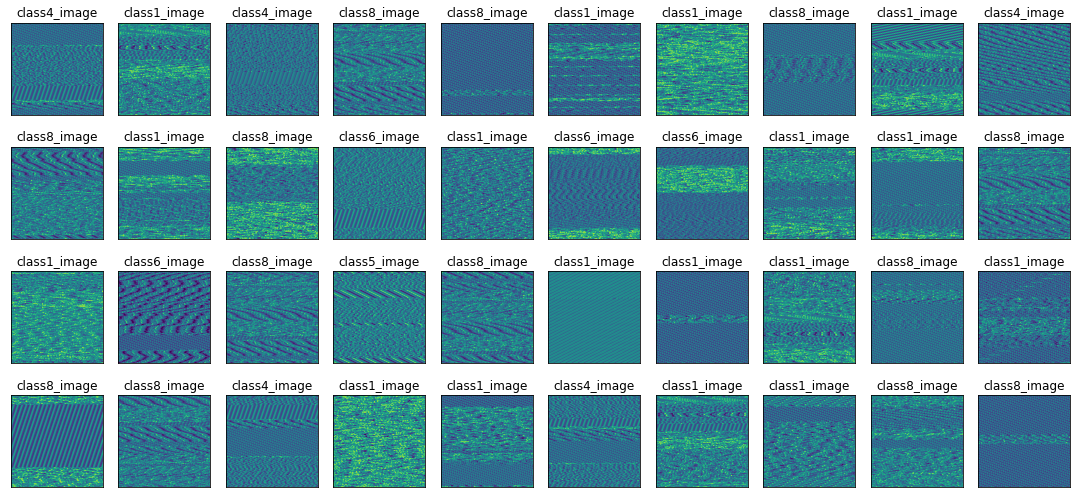

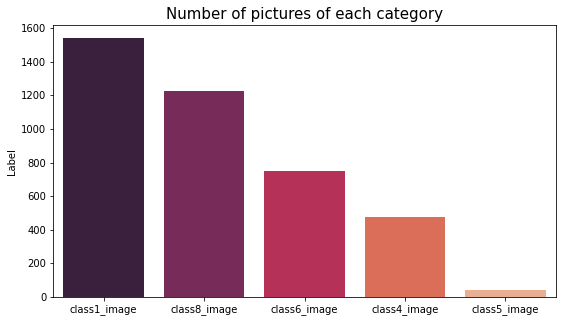

((3633, 2), (404, 2))

In [49]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

# 데이터 불러오기(드라이브 마운트)
from google.colab import drive
drive.mount('/content/drive')

# 이미지 경로를 데이터 프레임 형태로 만드는 함수
dir_ = Path('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata')
filepaths = list(dir_.glob(r'**/*.png')) # 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate, panda에 데이터프레임 합치는 함수.axis=1: 왼쪽+오른쪽으로 합치기
    df = pd.concat([filepath, labels], axis=1) 
                                              

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True) # dataframe에 랜덤하게 몇 %의 데이터를 뽑을 것인지.
                                                                   # frac=1:모든 데이터를 반환
    return df

df = proc_img(filepaths)
df.head(5)

print(f'Number of pictures: {df.shape[0]}\n') # Number of pictures: 13798
print(f'Number of different labels: {len(df.Label.unique())}\n') #Number of different labels: 8
print(f'Labels: {df.Label.unique()}') # unique()는 데이터에 고유값들이 어떠한 종류들이 있는지 알고 싶을 때 사용하는 함수
# Labels: ['person' 'airplane' 'car' 'dog' 'cat' 'flower' 'fruit' 'motorbike']

# 이미지 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), 
                        subplot_kw={'xticks': [], 'yticks': []}) # figsize:그래프 사이즈

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()
# fig란 figure로써 - 전체 subplot을 말한다. ex) 서브플로안에 몇개의 그래프가 있던지 상관없이  그걸 담는 하나. 전체 사이즈를 말한다.
# ax는 axe로써 - 전체 중 낱낱개를 말한다 ex) 서브플롯 안에 2개(a1,a2)의 그래프가 있다면 a1, a2 를 일컬음


# Label Category 분포 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

#이미지 데이터 Train, Test 데이터로 분류
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape


In [50]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                color_mode = 'grayscale',
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                             color_mode = 'grayscale',
                                                 class_mode = 'categorical',subset='validation')

Found 3231 images belonging to 5 classes.
Found 806 images belonging to 5 classes.


In [51]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 1]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 123008)            0         
                                                                 
 dense_18 (Dense)            (None, 128)              

In [52]:
#모델 성능확인
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10) #epochs는 학습 횟수

Epoch 1/10
101/101 [==============================] - 217s 2s/step - loss: 1.4223 - accuracy: 0.3918 - val_loss: 1.1613 - val_accuracy: 0.5347
Epoch 2/10
101/101 [==============================] - 213s 2s/step - loss: 1.0472 - accuracy: 0.5918 - val_loss: 0.9913 - val_accuracy: 0.6203
Epoch 3/10
101/101 [==============================] - 213s 2s/step - loss: 0.8500 - accuracy: 0.6989 - val_loss: 0.7904 - val_accuracy: 0.7581
Epoch 4/10
101/101 [==============================] - 214s 2s/step - loss: 0.6286 - accuracy: 0.8066 - val_loss: 0.7745 - val_accuracy: 0.7246
Epoch 5/10
101/101 [==============================] - 213s 2s/step - loss: 0.5086 - accuracy: 0.8326 - val_loss: 0.6686 - val_accuracy: 0.7742
Epoch 6/10
101/101 [==============================] - 213s 2s/step - loss: 0.3721 - accuracy: 0.8824 - val_loss: 0.7949 - val_accuracy: 0.7246
Epoch 7/10
101/101 [==============================] - 214s 2s/step - loss: 0.2522 - accuracy: 0.9248 - val_loss: 0.6197 - val_accuracy: 0.7916

In [ ]:
!unzip -qq /image.zip -d /content/drive/MyDrive/ColabNotebooks/CNN_Project/imagedata